# Step - 0

** Business Problem:** Urban wear is a clothing brand that's launching an eCommerce store. Currently, the pre launch page is collecting emails from site visitors. The plan is to collect as many emails for the product launch

As a product data scientist at urban wear, your job is to design, run and analyze an AB experiment that tests the two versions of the email sign up on the pre-launch page.

The control is the blue button which is the current version, the treatment is the green button.

Help the product team in deciding which version is better after analyzing the AB experiment

** Contact **

If you have any questions, please email engmazam786@gmail.com

In [56]:
## Importing libraries

from datetime import datetime
import random
import math

import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep

# Disable warnings
from warnings import filterwarnings
filterwarnings('ignore')

#Set seed
SEED = 123
np.random.seed(SEED)

## load Data

In [57]:
# Set data path and load data
data_path = './Data/'
pretest = pd.read_csv(data_path + 'pretest.csv')
print('Pretest Data imported')

test = pd.read_csv(data_path + 'test.csv')
print('Test Data Imported')

# Converting the date column to date_field
pretest['date'] = pd.to_datetime(pretest['date'])
test['date'] = pd.to_datetime(test['date'])

Pretest Data imported
Test Data Imported


# Understanding the Business Problem

The first crucial step in AB testing is understanding the business problem. So, in this case is to look at the daily visitors count and the current sign up rate and help the stakeholders in visualising it with the help of some charts how the current scenerio looks like

In [80]:
# Display the first five rows of the pre test table
pretest.head()

,visitor_id,date,email,experiment,group,submitted
0,1,2021-12-01,NaN,NaN,NaN,0
1,2,2021-12-01,NaN,NaN,NaN,0
2,3,2021-12-01,NaN,NaN,NaN,0
3,4,2021-12-01,NaN,NaN,NaN,0
4,5,2021-12-01,NaN,NaN,NaN,0


In [82]:
test['experiment'].unique()

array([nan, 'email_test'], dtype=object)

In [59]:
# Show some stats about the pretest table

print('The number of rows in the pretest table are ', pretest.shape[0])
print(f"The date range of the data collected is {pretest['date'].min()} to  {pretest['date'].max()}")

The number of rows in the pretest table are  309903
The date range of the data collected is 2021-12-01 00:00:00 to  2021-12-31 00:00:00


In [60]:
# Let's check for the missingness. What is the null rate per column?
pretest.isnull().mean()

visitor_id    0.000000
date          0.000000
email         0.899017
experiment    0.903070
group         0.903070
submitted     0.000000
dtype: float64

In [61]:
## Initial stats about the pretest
print('The total visiot count :', pretest['visitor_id'].nunique())
print('The total sign up count :', pretest['submitted'].sum())
print('The sign up rate :', pretest['submitted'].mean().round(2))

The total visiot count : 309903
The total sign up count : 31295
The sign up rate : 0.1


## Plot visitors per day

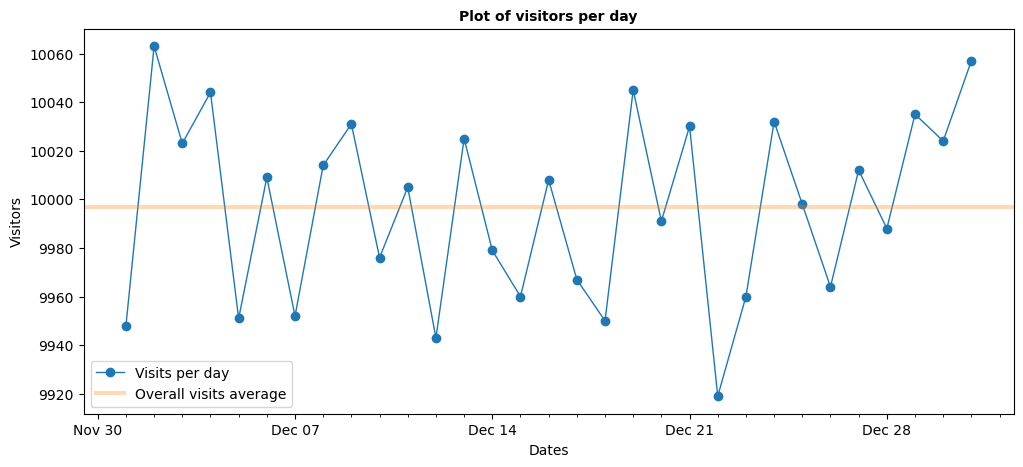

In [62]:
# Set the color palette for the plot
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

# Visitors per day and overall average
visits_per_day = pretest.groupby('date')['visitor_id'].count()
visits_mean = visits_per_day.mean()

#Plot Data
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(visits_per_day.index, visits_per_day, color=c1, linewidth=1, marker='o', label='Visits per day')
plt.axhline(visits_mean, color=c2, linewidth=3, alpha=0.3, label='Overall visits average')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())

plt.title('Plot of visitors per day', fontsize=10, fontweight='bold')
plt.xlabel('Dates', fontsize=10)
plt.ylabel('Visitors', fontsize=10)
plt.legend()
plt.show()

## Plot of sign up rate per day

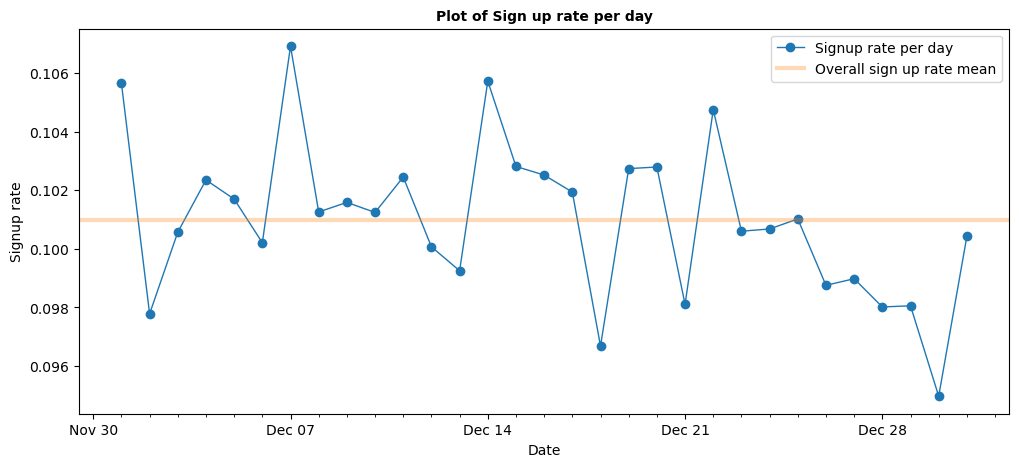

In [63]:
# sign up rate per day and it's mean
signup_rate_per_day = pretest.groupby('date')['submitted'].mean()
signup_rate_mean = signup_rate_per_day.mean()

#plot the graph
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(signup_rate_per_day.index, signup_rate_per_day, color=c1, marker='o', linewidth=1, label='Signup rate per day')
plt.axhline(signup_rate_mean, color=c2, linewidth=3, alpha=0.3, label='Overall sign up rate mean')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())

plt.title('Plot of Sign up rate per day', fontsize=10, fontweight='bold')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Signup rate', fontsize=10)
plt.legend()
plt.show()

# Step 1 - State the Hypothesis

The second step of the experiment is to state the hypothesis. This is followed by setting parameters like alpha, statistical power and minimum detectable effect

Ho - The sign rates of blue and green buttons are same

Ha- The sign up rates of blue and green buttons are different

In [64]:
# Setting some parameters
alpha = 0.05  # reject the null hypothesis, if the p value found is less than alpha
power = 0.80  # Ensure that there is an 80% percent chance of detecting an effect with statistical significance
mde = 0.10    # Detect a 10 percent increase in the signup rate with statistical significance

# Proportions if the effect exists
p1 = 0.10   # Control Green Button
p2 = p1 * (1+0.10)  #Treatment Blue Button

# Step 2 - Design the Experiment

The third step of the experiment is to design the experiment which involves determining the randomization unit, calculating the sample size and determining the experiment duration. We will explore how to calculate the sample size and experiment duration.

#### Calculate sample size

To detect an effect of 10.0% from an initial sign rate of 10%, The sample size required per group is 15000
The total sample required in the experiment is 30000


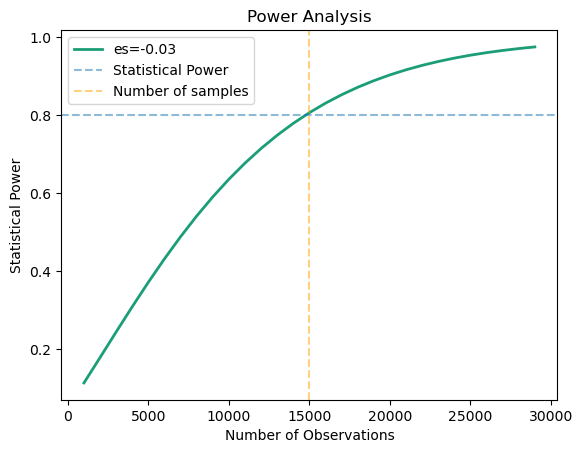

In [72]:
# Calculate the effect size using cohen'd for proportions
cohen_d = sm.stats.proportion_effectsize(p1, p2)

# To calculate the sample size n for the given cohen_d, power and alpha
n = tt_ind_solve_power(effect_size=cohen_d, alpha=alpha, power=power)
n = int(round(n, -3)) # Round up to nearest thousands

print(f'To detect an effect of {100*(p2/p1-1):.1f}% from an initial sign rate of {100*p1:.0f}%, '
      f'The sample size required per group is {n}'
      f'\nThe total sample required in the experiment is {2*n}')

# Explore power across all sample sizes
ttest_power = TTestIndPower()
ttest_power.plot_power(dep_var='nobs',nobs=np.arange(1000, 30000, 1000), effect_size=[cohen_d], title='Power Analysis')

plt.axhline(0.8, linestyle='--', label='Statistical Power', alpha=0.5)
plt.axvline(15000, linestyle='--', color='orange', alpha=0.5, label='Number of samples')
plt.legend()
plt.ylabel('Statistical Power')
plt.show()

#### Experiment duration

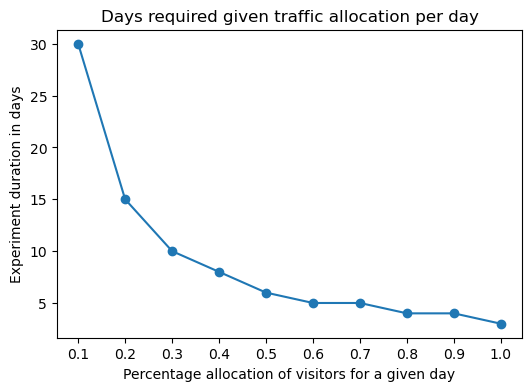

In [76]:
# What is the duration required to achieve the required sample size 
# given the percentage of unique visitors allocated to the experiment?

alloc = np.arange(0.10, 1.1, 0.10)
size = round(visits_mean, -3) * alloc
days = np.ceil(2 * n/ size)

# Plot the graph
f, ax = plt.subplots(figsize=(6,4))
ax.plot(alloc, days, '-o')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.set_title('Days required given traffic allocation per day')
plt.ylabel('Experiment duration in days')
ax.set_xlabel('Percentage allocation of visitors for a given day')
plt.show()

In [77]:
print(f'To run an experiment for 21 days , {np.ceil(2*n/21)} users are required per day')  # Too long
print(f'To run an experiment for 14 days , {np.ceil(2*n/14)} users are required per day')  # Sweet spot between risk and time
print(f'To run an experiment for 07 days , {np.ceil(2*n/7)} users are required per day')   # Too risky

To run an experiment for 21 days , 1429.0 users are required per day
To run an experiment for 14 days , 2143.0 users are required per day
To run an experiment for 07 days , 4286.0 users are required per day


# Step 4 - Run the experiment

We will look at the step analysing the AB experiment. The code below shows a simplified version about how data is collected and analyzed in a large scale experiment platform

In [91]:
# Get the subset tables of control and treatment group
AB_test = test[test['experiment'] == 'email_test']
control_signups = AB_test[AB_test['group']==0]
treatment_signups = AB_test[AB_test['group']==1]

control_signups_total = control_signups['submitted'].sum()
treatment_signups_total = treatment_signups['submitted'].sum()
control_signup_rate = control_signups['submitted'].mean()
treatment_signup_rate = treatment_signups['submitted'].mean()
control_signups_count = control_signups['submitted'].count()
treatment_signups_count = treatment_signups['submitted'].count()

print(f'Control signup rate : {control_signup_rate:.4}')
print(f'Treatment signup rate :{treatment_signup_rate:.4}')

Control signup rate : 0.09557
Treatment signup rate :0.1078


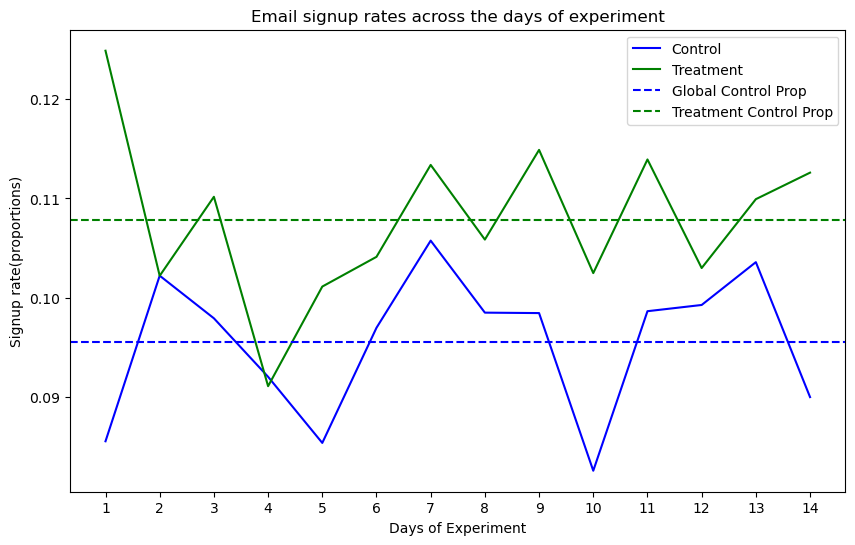

In [104]:
# Plot signups per day for each group
signups_per_day = AB_test.groupby(['group', 'date'])['submitted'].mean()
control_props = signups_per_day.loc[0]
trt_props = signups_per_day.loc[1]

# Get the days of experiment
days = range(1, AB_test['date'].nunique() + 1)

# Let's plot the sign rates of both control and treatment group with days
f, ax = plt.subplots(figsize=(10,6))

ax.plot(days, control_props, label='Control', color='b')
ax.plot(days, trt_props, label='Treatment', color='g')
ax.axhline(control_signup_rate, color='b', linestyle='--', label='Global Control Prop')
ax.axhline(treatment_signup_rate, color='g', linestyle='--', label='Treatment Control Prop')
plt.xticks(days)
plt.title('Email signup rates across the days of experiment')
plt.ylabel('Signup rate(proportions)')
plt.xlabel('Days of Experiment')
plt.legend()
plt.show()